<a href="https://colab.research.google.com/github/ronald-hk-chung/ComputerVision/blob/main/Faster_RCNN_implimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Faster R-CNN

Faster R-CNN is the final member of the family of multi-stage object detectors. Whiel Fast R-CNN improved training and inference times considerably, it was still getting penalized due to teh selective search algorithm. the Faster R-CNN model presented in 2016 by Ren et.al in their paper titled <a href="https://papers.nips.cc/paper/2015/file/14bfa6bb14875e45bba028a21ed38046-Paper.pdf">“Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks"</a> addresses the regional proposal aspect primarily. The network builds on top of Fast R-CNN network by introducign a novel component called `Regional Proposal Network (RPN)`. The overall Faster R-CNN network is as below

<img src='https://miro.medium.com/v2/resize:fit:720/format:webp/1*ONcbBe4mtiEr6Mq4iMkZ8A.png'>

RPN is a fully convolutional network (FCN) that helps in generating ROIs. RPN consists of two layers only. The first being a 3x3 convolutional layer with 512 filters followed by two parallel 1x1 convolutional layers (one each for classification and regression respectively). The 3x3 convolutional filter is applied onto the feature map output of the pre-trained network (the input to which is the original image). Please note that the classification layer in RPN is a binary clssification layer for determination of objectness score (not the object class). The bounding box regression si performed using the 1x1 convolutional filters on anchor boxes. The proposed setup in teh paper uses 9 anchor boxes per window, thus the RPN generates 18 objectness score (2xK) and 36 location coordinates (4xK), where K-9 is the number of anchor boxes. The use of RPN (instead of selective search) improves the training and inference times by orders of magnitude.

The Faster R-CNN network is an end-to-end object detection network. Unlike the base R-CNN and Fast R-CNN which made use of a number of independent components for training, Faster R-CNN can be trained as a whole.



## Notebook Setup

In [ ]:
!git clone https://github.com/ronald-hk-chung/TorchStep
!sh TorchStep/config.sh

Cloning into 'TorchStep'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 159 (delta 59), reused 148 (delta 48), pack-reused 0
Receiving objects: 100% (159/159), 31.32 KiB | 5.22 MiB/s, done.
Resolving deltas: 100% (59/59), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 64.6 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torchvision import transforms, models, datasets
from torchvision.ops import nms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from TorchStep.vision_utils import show_image
from TorchStep.engine import TSEngine
from PIL import Image
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import cv2

## Download Dataset - Google Open Image v6 dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
from google.colab import files
files.upload() # upload kaggle.json
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
# Download images_bus_trucks and unzip
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 69 Feb 17 15:36 kaggle.json
 99% 364M/367M [00:17<00:00, 24.3MB/s]
100% 367M/367M [00:17<00:00, 22.3MB/s]


In [ ]:
IMAGE_ROOT = Path('images/images')
df = pd.read_csv('df.csv')
df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [ ]:
label2target = {l:t+1 for t, l in enumerate(df['LabelName'].unique())}
label2target['Background'] = 0
target2label = {t:l for l, t in label2target.items()}
background_class = label2target['Background']
num_classes = len(label2target)

In [ ]:
label2target

{'Bus': 1, 'Truck': 2, 'Background': 0}

## Prepare Dataset and DataLoader

In [ ]:
import torch
from torchvision.transforms import v2 as T
tfms = T.Compose([T.ToImage(),
                  T.ToDtype(torch.float32, scale=True),
                  T.Resize(size=(224, 224), antialias=True)])

In [ ]:
import random
sample_id = random.sample(df['ImageID'].unique().tolist(), 1000)
df = df[df['ImageID'].isin(sample_id)]

In [ ]:
class OpenImages(Dataset):
  w, h = 224, 224
  def __init__(self, df, image_dir=IMAGE_ROOT):
    self.image_dir = image_dir
    self.df = df
    self.unique_images = self.df['ImageID'].unique()
  def __len__(self):
    return len(self.unique_images)
  def __getitem__(self, idx):
    image_id = self.unique_images[idx]
    img_path = self.image_dir / f'{image_id}.jpg'
    img = tfms(Image.open(img_path).convert('RGB'))
    data = df[df['ImageID']==image_id]
    labels = data['LabelName'].values.tolist()
    data = data[['XMin', 'YMin', 'XMax', 'YMax']].values
    data[:, [0,2]] *= self.w  # Scale to absolute coordinates for X
    data[:, [1,3]] *= self.h  # Scale to absolute coordinates for Y
    boxes = data.astype(np.uint32).tolist()
    # Torch FRCNN expects ground truths as a dictionary of tensors
    # https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html
    target = {}
    target['boxes'] = torch.Tensor(boxes).float() # the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
    target['labels'] = torch.Tensor([label2target[i] for i in labels]).long() #  the class label for each ground-truth box
    return img, target
  def collate_fn(self, batch):
    # by default, collate_fn works ony with tensors as inputs, we need to deal with a list of dictionaries
    return tuple(zip(*batch))

ds = OpenImages(df)

In [ ]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(df['ImageID'].unique(), test_size=0.1)
train_df = df[df['ImageID'].isin(train_ids)]
valid_df = df[df['ImageID'].isin(valid_ids)]

train_ds = OpenImages(train_df)
valid_ds = OpenImages(valid_df)

train_dl = DataLoader(dataset=train_ds,
                      batch_size=8,
                      collate_fn=train_ds.collate_fn,
                      drop_last=True)
valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=8,
                      collate_fn=valid_ds.collate_fn,
                      drop_last=True)

In [ ]:
batch = next(iter(train_dl))

In [ ]:
# batch[0] contains img
batch[0]

(Image([[[0.3176, 0.3449, 0.3739,  ..., 0.3464, 0.3194, 0.4458],
         [0.3114, 0.3171, 0.3388,  ..., 0.3471, 0.3389, 0.4520],
         [0.2993, 0.2888, 0.3047,  ..., 0.3467, 0.3579, 0.4506],
         ...,
         [0.4190, 0.4170, 0.4309,  ..., 0.6524, 0.6223, 0.5721],
         [0.4340, 0.4303, 0.4505,  ..., 0.6634, 0.6419, 0.6122],
         [0.4582, 0.4614, 0.4800,  ..., 0.6906, 0.6558, 0.6373]],
 
        [[0.3451, 0.3669, 0.3817,  ..., 0.3386, 0.3200, 0.4595],
         [0.3313, 0.3350, 0.3487,  ..., 0.3363, 0.3395, 0.4657],
         [0.3095, 0.3030, 0.3166,  ..., 0.3349, 0.3597, 0.4672],
         ...,
         [0.4009, 0.4002, 0.4176,  ..., 0.6258, 0.5957, 0.5454],
         [0.4144, 0.4129, 0.4387,  ..., 0.6398, 0.6183, 0.5887],
         [0.4386, 0.4440, 0.4682,  ..., 0.6671, 0.6322, 0.6137]],
 
        [[0.3176, 0.3460, 0.3778,  ..., 0.3534, 0.3346, 0.4719],
         [0.3189, 0.3264, 0.3508,  ..., 0.3502, 0.3505, 0.4731],
         [0.3193, 0.3120, 0.3265,  ..., 0.3445, 0.3644, 

In [ ]:
# batch[1] contains targets {boxes: tensor, labels: tensor}
batch[1]

({'boxes': tensor([[ 77.,  34., 203., 145.]]), 'labels': tensor([1])},
 {'boxes': tensor([[ 11.,  41., 132., 184.]]), 'labels': tensor([2])},
 {'boxes': tensor([[120., 109., 170., 178.]]), 'labels': tensor([1])},
 {'boxes': tensor([[ 23.,  80., 197., 193.],
          [159.,  18., 216.,  51.]]),
  'labels': tensor([2, 2])},
 {'boxes': tensor([[ 67.,  59., 164., 179.],
          [128.,  29., 223., 221.]]),
  'labels': tensor([2, 2])},
 {'boxes': tensor([[ 14.,  21., 200., 209.]]), 'labels': tensor([1])},
 {'boxes': tensor([[  0.,  40., 223., 172.]]), 'labels': tensor([2])},
 {'boxes': tensor([[ 63.,  17., 164., 213.],
          [198., 130., 214., 149.]]),
  'labels': tensor([1, 1])})

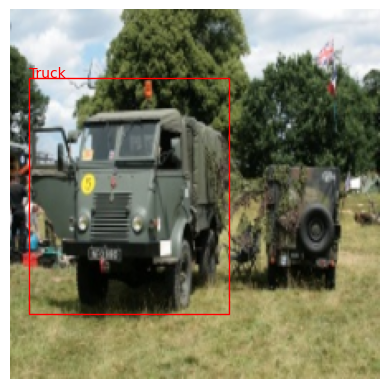

In [ ]:
import matplotlib.pyplot as plt
img_id = 1
img = torchvision.transforms.ToPILImage()(batch[0][img_id])
bbs = batch[1][img_id]['boxes'].tolist()
bbs_label = [target2label[i] for i in batch[1][img_id]['labels'].tolist()]
show_image(img=img,
           bbs=bbs,
           bbs_format='XYXY',
           bbs_label=bbs_label)

## Get pretrained fasterrcnn_resnet50_fpn

https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html

Faster R-CNN model with a ResNet-50-FPN backbone from the Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks paper.
https://arxiv.org/abs/1506.01497

The `FastRCNNPredictor` class is a component of the Python `torchvision.models.detection` module in the `faster_rcnn` package. It is used in the Faster R-CNN model for object detection in PyTorch. This class is responsible for predicting bounding box coordinates and class scores for each object in an image. It takes the output features from the backbone network and applies fully connected layers to generate the final predictions. The `FastRCNNPredictor` aids in transforming the intermediate feature maps into human-understandable information required for object detection tasks.

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model():
  """Function to change roi_heads using FastRCNNPredictor for custom dataset"""
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

In [ ]:
## FastRCNNPredictor produce Linear Layer for cls_score and bbox_pred to num_classes
FastRCNNPredictor(1024, 2)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)

## Investigating fasterrcnn_resnet50_fpn model

1. Feature Pyramid Network (fpn)

http://arxiv.org/abs/1612.03144v2
https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c

A Feature Pyramid Network, or FPN, is a feature extractor that takes a single-scale image of an arbitrary size as input, and outputs proportionally sized feature maps at multiple levels, in a fully convolutional fashion. This process is independent of the backbone convolutional architectures. It therefore acts as a generic solution for building feature pyramids inside deep convolutional networks to be used in tasks like object detection.

The construction of the pyramid involves a bottom-up pathway and a top-down pathway.

The bottom-up pathway is the feedforward computation of the backbone ConvNet, which computes a feature hierarchy consisting of feature maps at several scales with a scaling step of 2. For the feature pyramid, one pyramid level is defined for each stage. The output of the last layer of each stage is used as a reference set of feature maps. For ResNets we use the feature activations output by each stage’s last residual block.

The top-down pathway hallucinates higher resolution features by upsampling spatially coarser, but semantically stronger, feature maps from higher pyramid levels. These features are then enhanced with features from the bottom-up pathway via lateral connections. Each lateral connection merges feature maps of the same spatial size from the bottom-up pathway and the top-down pathway. The bottom-up feature map is of lower-level semantics, but its activations are more accurately localized as it was subsampled fewer times.

<img src=https://miro.medium.com/v2/resize:fit:720/format:webp/1*Hi3mCsgTEjPLtWnRyXx47w.jpeg>

FPN is not an object detector by itself. It is a feature extractor that works with object detectors.

<img src=https://miro.medium.com/v2/resize:fit:1100/format:webp/1*Wvn0WG4XZ0w9Ed2fFYPrXw.jpeg>



In [ ]:
model = get_model()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 148MB/s]


`GeneralizedRCNNTrasnform` is a simple resize followed by a normalize transformation

In [ ]:
model.transform

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)

`BackBoneWithFPN` is a neural netowrk that transforms input into a feature map

In [ ]:
model.backbone

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=0.0)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256, eps=0.0)
        )
      )
      (1): Bottleneck(
        (conv1): C

`RegionProposalNetwork` generates the anchor boxes for the preceding featuremap and predicts individual feature maps for classification and regression tasks:

RPN is part of the object dection netowrk. Using an `RPN`, we are now in position where we don't have ot perform unnecessary computations like `selectivesearch` to calculate region proposas outside of the network.

In [ ]:
model.rpn

RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)

`RoIHeads` takes the preceding maps aligns them using RoI pooling, processes them, and returns classification probabilities for each proposal and the corresponding offsets

In [ ]:
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=3, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=12, bias=True)
  )
)

## Behaviour of Faster RCNN resnet50 fpn model

The behaviour of the model changes depending on if it is in training or evaluation mode.

**During training,** the model expects both the input tensors and a target (list of dictionary), containing:


*   boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
*   labels (Int64Tensor[N]): the class label for each ground-truth box

The model returns a Dict[Tensor] during training, containing the classification and regression losses for both the RPN and the R-CNN.


**During inference,** the model requires only the input tensors, and returns the post-processed predictions as a List[Dict[Tensor]], one for each input image. The fields of the Dict are as follows, where N is the number of detections:



*   boxes (FloatTensor[N, 4]): the predicted boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
*   labels (Int64Tensor[N]): the predicted labels for each detection
*   scores (Tensor[N]): the scores of each detection





In [ ]:
img_tensor, target_dict = batch

In [ ]:
model.train()
losses = model(img_tensor, target_dict)

In [ ]:
losses

{'loss_classifier': tensor(1.5501, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1927, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0123, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0042, grad_fn=<DivBackward0>)}

In [ ]:
model.eval()
targets = model(img_tensor)

In [ ]:
targets[0]

{'boxes': tensor([[179.8115,  67.2053, 184.9952,  72.4467],
         [178.4816,  67.1988, 182.8887,  72.8837],
         [150.5057,  64.5783, 155.1526,  72.9929],
         [136.1859, 130.2072, 153.4508, 215.5163],
         [ 65.7895,  96.4965,  81.1115, 123.1255],
         [167.9077,  64.8604, 171.3578,  71.1463],
         [163.7858,  61.9569, 171.2624,  71.1904],
         [149.1690,  63.1848, 157.5825,  72.3338],
         [214.2008, 124.0418, 224.0000, 139.4755],
         [168.9012,  66.0200, 173.2081,  71.1943],
         [162.0305,  63.2580, 166.4908,  71.2725],
         [140.3622,  51.3484, 206.1810, 153.0656],
         [139.6191,  19.5550, 222.8368, 205.4771],
         [  0.6253,   1.9322,  19.5161,  32.4984],
         [  2.8805,   6.4275,  18.6621,  57.7688],
         [170.8214,  65.3729, 174.2089,  72.5513],
         [ 81.5825, 138.4863, 107.3231, 220.8030],
         [188.1702,  65.3962, 193.4825,  75.5812],
         [147.0170, 104.8835, 152.4771, 114.0431],
         [ 32.5446, 11

In [ ]:
target_dict[0]

{'boxes': tensor([[ 77.,  34., 203., 145.]]), 'labels': tensor([1])}

## Define training and validation loop

In [ ]:
class FasterRCNN(TSEngine):
  def __init__(self, optim, train_dataloader, valid_dataloader):
    super().__init__(model=self.get_model(),
                     optim=optim,
                     loss_fn=self.faster_rcnn_loss,
                     metric_fn=self.faster_rcnn_metric,
                     train_dataloader=train_dataloader,
                     valid_dataloader=valid_dataloader)

  def get_model(self):
    """Function to change roi_heads using FastRCNNPredictor for custom dataset"""
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

  def faster_rcnn_loss(self, losses):
    return sum(list(losses.values()))

  def faster_rcnn_metric(self, losses):
    return {k: v.cpu().detach().numpy() for k, v in losses.items()}

  def train_step(self):
    input, targets = self.batch
    losses = self.model(input, targets)
    loss = self.loss_fn(losses)
    metric = self.metric_fn(losses)
    return loss, metric

  def valid_step(self):
    input, targets = self.batch
    losses = self.model(input, targets)
    loss = self.loss_fn(losses)
    metric = self.metric_fn(losses)
    return loss, metric

  def set_valid_mode(self):
    self.model.train()

In [ ]:
frcnn = FasterRCNN(optim=(torch.optim.SGD, {'lr': 0.005, 'momentum': 0.9, 'weight_decay': 0.0005}),
                   train_dataloader=train_dl,
                   valid_dataloader=valid_dl)

In [ ]:
frcnn.train(5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train Step:   0%|          | 0/112 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | LR: 5.0E-03 | train_loss: 0.278 | valid_loss: 0.222 
train_metric: {'loss_classifier': 0.116, 'loss_box_reg': 0.131, 'loss_objectness': 0.022, 'loss_rpn_box_reg': 0.009}
valid_metric: {'loss_classifier': 0.086, 'loss_box_reg': 0.089, 'loss_objectness': 0.034, 'loss_rpn_box_reg': 0.013}


Train Step:   0%|          | 0/112 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 2 | LR: 5.0E-03 | train_loss: 0.167 | valid_loss: 0.201 
train_metric: {'loss_classifier': 0.067, 'loss_box_reg': 0.083, 'loss_objectness': 0.01, 'loss_rpn_box_reg': 0.007}
valid_metric: {'loss_classifier': 0.08, 'loss_box_reg': 0.081, 'loss_objectness': 0.028, 'loss_rpn_box_reg': 0.012}


Train Step:   0%|          | 0/112 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 3 | LR: 5.0E-03 | train_loss: 0.137 | valid_loss: 0.217 
train_metric: {'loss_classifier': 0.053, 'loss_box_reg': 0.072, 'loss_objectness': 0.005, 'loss_rpn_box_reg': 0.006}
valid_metric: {'loss_classifier': 0.087, 'loss_box_reg': 0.085, 'loss_objectness': 0.032, 'loss_rpn_box_reg': 0.012}


Train Step:   0%|          | 0/112 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 4 | LR: 5.0E-03 | train_loss: 0.118 | valid_loss: 0.225 
train_metric: {'loss_classifier': 0.045, 'loss_box_reg': 0.064, 'loss_objectness': 0.004, 'loss_rpn_box_reg': 0.005}
valid_metric: {'loss_classifier': 0.093, 'loss_box_reg': 0.083, 'loss_objectness': 0.037, 'loss_rpn_box_reg': 0.012}


Train Step:   0%|          | 0/112 [00:00<?, ?it/s]

Valid Step:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 5 | LR: 5.0E-03 | train_loss: 0.102 | valid_loss: 0.235 
train_metric: {'loss_classifier': 0.036, 'loss_box_reg': 0.058, 'loss_objectness': 0.003, 'loss_rpn_box_reg': 0.005}
valid_metric: {'loss_classifier': 0.098, 'loss_box_reg': 0.085, 'loss_objectness': 0.039, 'loss_rpn_box_reg': 0.012}


In [ ]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

In [ ]:
image, target = next(iter(valid_dl))

In [ ]:
image = tuple(img.to('cuda') for img in image)
frcnn.model.eval()
outputs = frcnn.model(image)

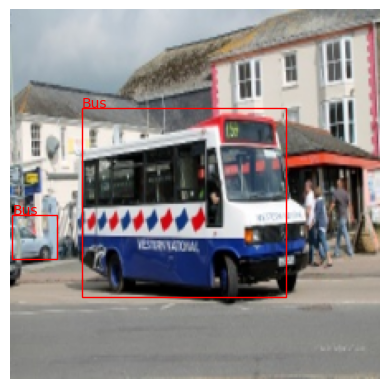

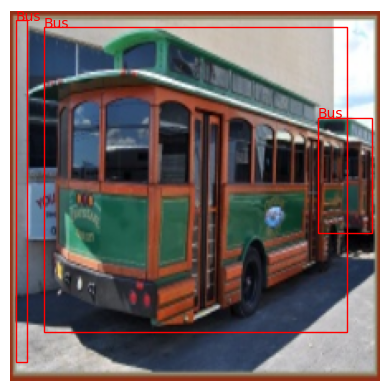

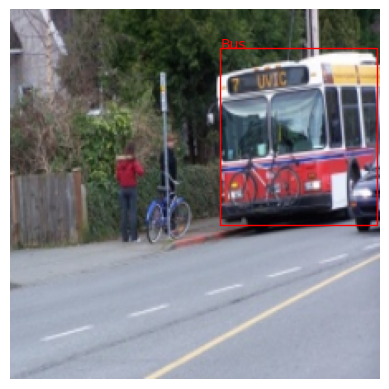

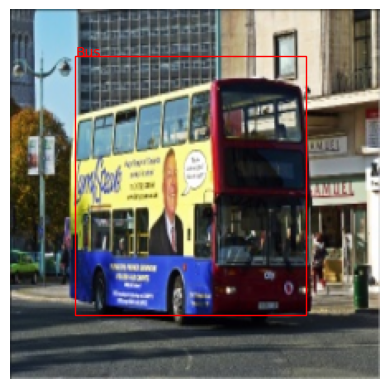

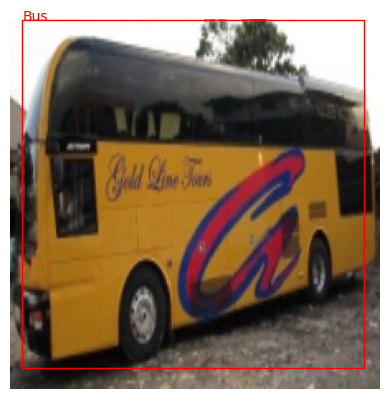

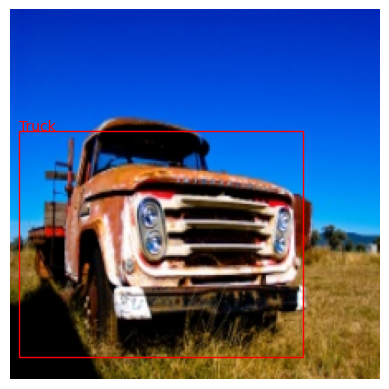

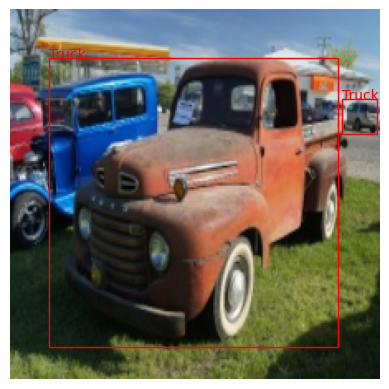

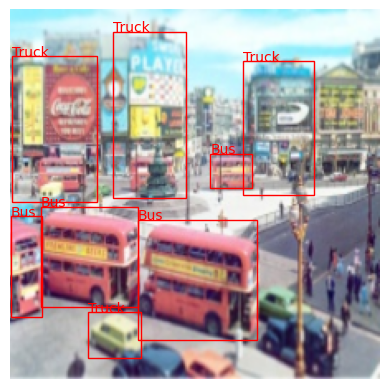

In [ ]:
for ix, output in enumerate(outputs):
  bbs, confs, labels = decode_output(output)
  img = torchvision.transforms.ToPILImage()(image[ix])
  show_image(img=img,
             bbs=bbs,
             bbs_format='XYXY',
             bbs_label=labels)